# Alzheimers Prediction Model

Training a Deep Neural Network to classify images of brain MRI scans to identify Dementia and Non-Dementia Patients.

# Import Libraries

In [ ]:
import os
import random
import zipfile
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split, ConcatDataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# Initiliaze device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [ ]:
class AlzheimerDataset(Dataset):
  def __init__(self):
    super().__init__()

    self.transform = transforms.Compose(
        [ transforms.ToTensor(),
          transforms.Resize((176,176)),
          # transforms.Grayscale(num_output_channels=1),
          transforms.Normalize(0, 1)])

    # Define paths to train and test data inside the zip file
    zip_file_path = 'alzheimer.zip'

    # Define paths to train and test data
    train_data_path = 'Alzheimer_s Dataset/train'
    test_data_path = 'Alzheimer_s Dataset/test'

    with zipfile.ZipFile('alzheimer.zip', 'r') as zip_ref:
      zip_ref.extractall(path='', members=[member for member in zip_ref.namelist() if member.startswith('Alzheimer_s Dataset/')])


    # Create datasets
    self.dataset = datasets.ImageFolder('Alzheimer_s Dataset/', transform=self.transform)

    # Load the train dataset using ImageFolder
    self.train_dataset = datasets.ImageFolder(train_data_path, transform=self.transform)

    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(self.train_dataset))
    val_size = len(self.train_dataset) - train_size
    self.train_dataset, self.val_dataset = random_split(self.train_dataset, [train_size, val_size])

    self.test_dataset = datasets.ImageFolder(test_data_path, transform=self.transform)

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      image, label = self.dataset[idx]
      # Further processing if needed
      return image, label

# Explore the Dataset


In [ ]:
data_obj = AlzheimerDataset()

In [ ]:
print('Length of training data:',len(data_obj.train_dataset))
print('Length of validation data:',len(data_obj.val_dataset))
print('Length of test data:',len(data_obj.test_dataset))

Length of training data: 4096
Length of validation data: 1025
Length of test data: 1279


In [ ]:
print('Shape of training images: ',data_obj.train_dataset[0][0].shape)

Shape of training images:  torch.Size([3, 208, 176])


{0: 717, 1: 52, 2: 2560, 3: 1792}


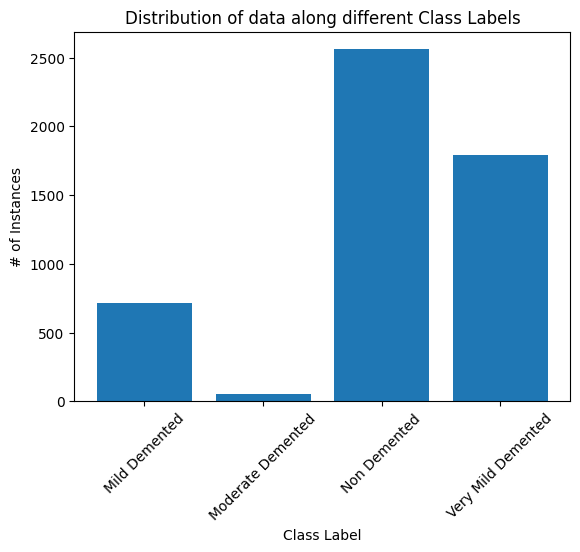

In [ ]:
class_map = {0:'Mild Demented', 1:'Moderate Demented', 2:'Non Demented', 3:'Very Mild Demented'}

targets = data_obj.train_dataset.dataset.targets
class_dict = dict(Counter(targets))
print(class_dict)
plt.bar(class_map.values(), class_dict.values())
plt.xlabel('Class Label')
plt.ylabel('# of Instances')
plt.title('Distribution of data along different Class Labels')
plt.xticks(rotation=45)
plt.show()

We are using an Alzheimer's dataset that has images of brain scan categorized into four catogories:
1. Mild Demented

2. Moderate Demented

3. Non Demented

4. Very Mild Demented

The dataset is ***not evenly distributed*** among these 4 classes, where theres only 52 instances for "Moderately Demented" and 2560 data instaces for "Non Demented".

The images shape is 208*176 and has 3 channels (RGB image).


## Visualize the original images

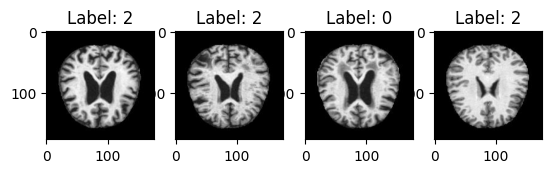

In [ ]:
## Visualize random batch of images
# Define DataLoader for test dataset
test_loader = DataLoader(data_obj.test_dataset, batch_size=4, shuffle=True)

image, labels = next(iter(test_loader))
# Transpose the image data to channels-last format (H x W x C)
image = image.numpy().transpose((0, 2, 3, 1))

# Create subplots
fig, ax = plt.subplots(1, 4)

# Plot each image in a subplot
for i in range(4):
    ax[i].imshow(image[i])
    ax[i].set_title(f"Label: {labels[i]}")

plt.show()

# Preprocess  - Balance the datatset

The dataset exhibits significant class imbalance, a common occurrence in medical imaging data, where instances of individuals without a certain condition often outnumber those with the condition.

To address this issue, I employed and compared two data augmentation techniques to boost the number of instances in underrepresented classes.

First, I utilized SMOTE (Synthetic Minority Over-sampling Technique), which equalized the instance counts across all classes.

Second, I manually augmented the data for each class, ensuring that while each label had sufficient instances for training, the overall distribution of data remained consistent. This approach maintained the relative differences in instance counts between labels, preserving the general distribution of the dataset.

 717	 52	2560	1792

1122 	410	0	 500?

------------------------------
1275	267	2560	2292		- Most balanced

1839	462	2560	1792		- Almost Balanced

1833	462	2560	2292		- 2nd balanced

## Technique 1 - Balance dataset using SMOTE

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

class AlzheimerSMOTEDataset(Dataset):
  def __init__(self):
    super().__init__()

    self.transform = transforms.Compose(
        [ transforms.ToTensor(),
          transforms.Resize((176,176)),
          transforms.Normalize(0, 1)])

    # Define paths to train and test data inside the zip file
    zip_file_path = 'alzheimer.zip'

    # Define paths to train and test data
    train_data_path = 'Alzheimer_s Dataset/train'
    test_data_path = 'Alzheimer_s Dataset/test'

    with zipfile.ZipFile('alzheimer.zip', 'r') as zip_ref:
      zip_ref.extractall(path='', members=[member for member in zip_ref.namelist() if member.startswith('Alzheimer_s Dataset/')])


    # Create datasets
    self.dataset = datasets.ImageFolder('Alzheimer_s Dataset/', transform=self.transform)

    # Load the train dataset using ImageFolder
    self.train_dataset = datasets.ImageFolder(train_data_path, transform=self.transform)

    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(self.train_dataset))
    val_size = len(self.train_dataset) - train_size
    self.train_dataset, self.val_dataset = random_split(self.train_dataset, [train_size, val_size])

    # Apply SMOTE to the training dataset
    X_train, y_train = zip(*self.train_dataset)
    X_train = np.array([np.array(x) for x in X_train])
    y_train = np.array(y_train)

    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 176*176*3), y_train)

    self.train_dataset = [(torch.tensor(x.reshape(3, 176, 176), dtype=torch.float32), y) for x, y in zip(X_train_resampled, y_train_resampled)]


    self.test_dataset = datasets.ImageFolder(test_data_path, transform=self.transform)

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      image, label = self.dataset[idx]
      return image, label

data_obj = AlzheimerSMOTEDataset()

{3: 2044, 2: 2044, 0: 2044, 1: 2044}


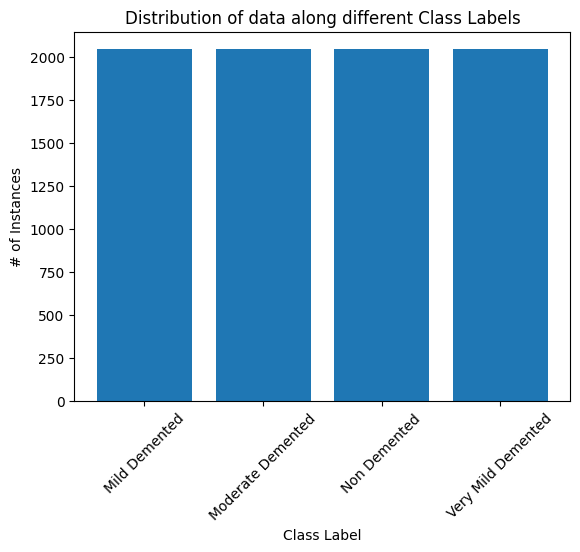

In [ ]:
# Update class_map according to the actual classes in the dataset
class_map = {0: 'Mild Demented', 1: 'Moderate Demented', 2: 'Non Demented', 3: 'Very Mild Demented'}

# Get the actual classes from the train_dataset
targets = [label for _, label in data_obj.train_dataset]

# Count the occurrences of each class
class_dict = dict(Counter(targets))

# Plot the distribution
plt.bar(class_dict.keys(), class_dict.values())

print(class_dict)

# Set labels and title
plt.xlabel('Class Label')
plt.ylabel('# of Instances')
plt.title('Distribution of data along different Class Labels')

# Set xticks according to the updated class_map
plt.xticks(list(class_map.keys()), class_map.values(), rotation=45)

# Show the plot
plt.show()


## Technique 2 - Augmentation for Balanced Distribution

Manually balance the images, ensuring that while each label had sufficient instances for training, the overall distribution of data remained consistent.

In [ ]:
data_obj = AlzheimerDataset()

In [ ]:
# Create seperate lists of images for each label
images_label0 = list()
images_label1 = list()
images_label3 = list()

for data in data_obj.train_dataset:
    # print(data, data[0],data[1])
    if data[1] == 0:
      images_label0.append(data[0])
    elif data[1] == 1:
      images_label1.append(data[0])
    elif data[1] == 3:
      images_label3.append(data[0])
print(len(images_label0),len(images_label1),len(images_label3))

558 42 1439


In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees= random.randint(1, 20)),#30),      # Randomly rotate the image
    transforms.RandomHorizontalFlip(p=random.uniform(0.2,0.7)),    # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=random.uniform(0.2,0.7)),      # Randomly flip the image vertically
])

augmented_images0 = list()
augmented_images1 = list()
augmented_images3 = list()

# Add 5 batches of transformed images
for _ in range(0,10):
  # Apply the transformations to each image tensor in the list
  augmented_image_batch = [transform(img) for img in images_label1]
  augmented_images1.extend(augmented_image_batch)

for _ in range(0,1):
  # Apply the transformations to each image tensor in the list
  augmented_image_batch = [transform(img) for img in images_label0]
  augmented_images0.extend(augmented_image_batch)

for _ in range(0,1):
  images_label3 = images_label3[:500]
  # Apply the transformations to each image tensor in the list
  augmented_image_batch = [transform(img) for img in images_label3]
  augmented_images3.extend(augmented_image_batch)

print(len(augmented_images0),len(augmented_images1),len(augmented_images3))

558 420 500


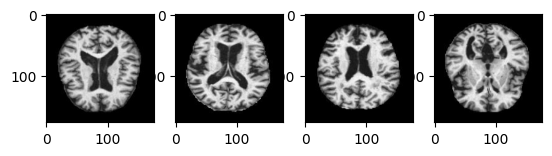

In [ ]:
# Visualize the augmented images

# Pick 4 random images
# indices = [random.randint(0, len(augmented_images)-1) for _ in range(4)]
indices = random.sample(range(1, len(augmented_images0)-1), 4)

# Ensure that the pixel values are in the range [0, 1]
image = np.clip(augmented_images0, 0, 1)

# Create subplots
fig, ax = plt.subplots(1, 4)

# Plot each image in a subplot
for i in range(4):
    ax[i].imshow(image[i].transpose((1, 2, 0)))

plt.show()

In [ ]:
# Create the augmented data list
augmented_data = list()
augmented_data.extend((img, 0) for img in augmented_images0)
augmented_data.extend((img, 1) for img in augmented_images1)
augmented_data.extend((img, 3) for img in augmented_images3)
len(augmented_data)


1988

In [ ]:
from torch.utils.data import Dataset, ConcatDataset

class AlzAugmentedDataset(Dataset):
    def __init__(self, original_dataset, augmented_data):
        self.original_dataset = original_dataset
        self.augmented_data = augmented_data

    def __len__(self):
        return len(self.original_dataset) + len(self.augmented_data)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            idx -= len(self.original_dataset)
            return self.augmented_data[idx]

# Combine both datasets into one
data_obj = AlzheimerDataset()
combined_dataset = AlzAugmentedDataset(data_obj.train_dataset, augmented_data)

# Define Model

In [ ]:
# Create a neural net class
class AlzModel(nn.Module):

    # Defining the Constructor
    def __init__(self, num_classes):
        super(AlzModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=15488, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)

        self.bn1 = nn.BatchNorm2d(16)  # Add batch normalization
        self.bn2 = nn.BatchNorm2d(32)  # Add batch normalization

        self.dropout = nn.Dropout(0.5)

        # Apply He initialization to the ReLU-based layers
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = self.bn1(x)
        x = F.relu(self.pool(self.conv2(x)))
        x = self.bn2(x)
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))

        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = AlzModel(num_classes=4).to(device)

print(model)

AlzModel3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15488, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training and Testing

#### Training the Model on SMOTE augmented data

Epoch 0:, Training Loss: 0.0143, Training Accuracy: 60.5698, Validation Loss: 0.0186, Validation Accuracy: 71.3171
Epoch 1:, Training Loss: 0.0095, Training Accuracy: 74.8027, Validation Loss: 0.0184, Validation Accuracy: 69.6585
Epoch 2:, Training Loss: 0.0075, Training Accuracy: 81.3888, Validation Loss: 0.0178, Validation Accuracy: 74.7317
Epoch 3:, Training Loss: 0.0061, Training Accuracy: 85.5575, Validation Loss: 0.0213, Validation Accuracy: 68.9756
Epoch 4:, Training Loss: 0.0050, Training Accuracy: 88.3942, Validation Loss: 0.0184, Validation Accuracy: 74.1463
Epoch 5:, Training Loss: 0.0040, Training Accuracy: 91.3789, Validation Loss: 0.0174, Validation Accuracy: 78.9268
Epoch 6:, Training Loss: 0.0032, Training Accuracy: 93.9073, Validation Loss: 0.0172, Validation Accuracy: 78.8293
Epoch 7:, Training Loss: 0.0026, Training Accuracy: 94.9556, Validation Loss: 0.0179, Validation Accuracy: 79.7073
Epoch 8:, Training Loss: 0.0020, Training Accuracy: 96.9413, Validation Loss: 0.

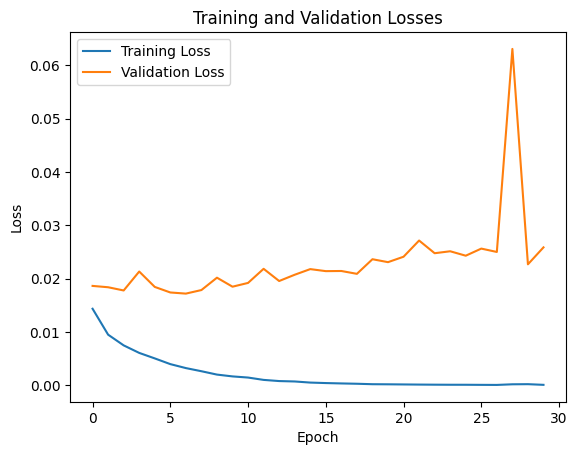

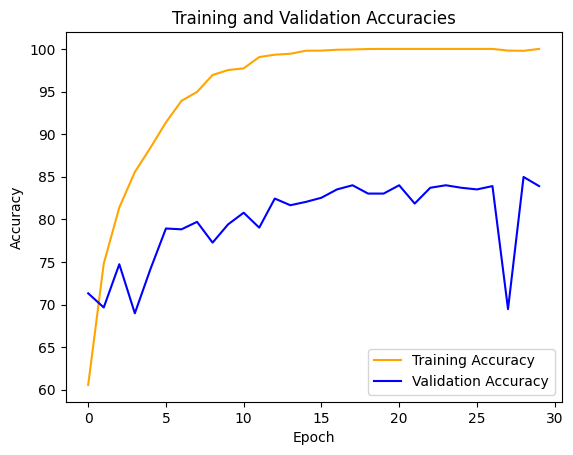

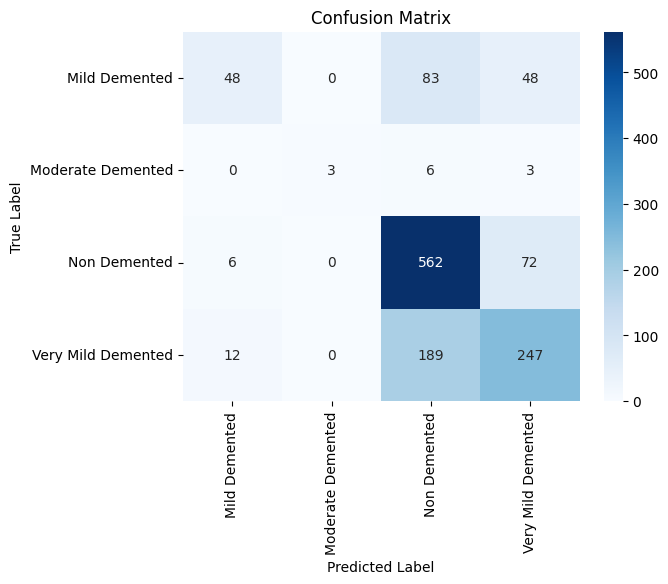


F1 Score:  0.6501527731050991


In [ ]:
# MAIN PROGRAM
data_obj = AlzheimerSMOTEDataset()
model = AlzModel3(num_classes=4).to(device)

#------------------------------------------------------------------------------
#     TRAINING AND VALIDATION
#------------------------------------------------------------------------------
batch_size = 64
num_epochs = 30
total_train = len(data_obj.train_dataset)  # Total data points in the training dataset
total_val = len(data_obj.val_dataset)  # Total data points in the validation dataset
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train_dataloader = DataLoader(data_obj.train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(data_obj.test_dataset, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0005)

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_correct = 0
    train_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predictions = torch.max(outputs.data, 1)
        train_correct += torch.sum(predictions == labels).item()

    train_losses.append(train_loss / total_train)
    train_accuracy = 100.0 * train_correct / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predictions = torch.max(outputs.data, 1)
            val_correct += torch.sum(predictions == labels).item()

    val_losses.append(val_loss / total_val)
    val_accuracy = 100.0 * val_correct / total_val
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch}:, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# PLOT THE LOSSES
plt.plot(list(range(num_epochs)), train_losses, label='Training Loss')
plt.plot(list(range(num_epochs)), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

# PLOT THE ACCURACIES
plt.plot(list(range(num_epochs)), train_accuracies, label='Training Accuracy', color='orange')
plt.plot(list(range(num_epochs)), val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.show()


#------------------------------------------------------------------------------
#     TESTING
#------------------------------------------------------------------------------

model.eval()
test_dataloader = DataLoader(data_obj.test_dataset, batch_size=batch_size)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs.data, 1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
confusion = confusion_matrix(all_labels, all_preds)
# Define class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
# Plot confusion matrix
sns.heatmap(np.array(confusion), annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
print('\nF1 Score: ',f1)

#### Training the model on Balanced Distribution

Epoch 0:, Training Loss: 0.0188, Training Accuracy: 43.8656, Validation Loss: 0.0195, Validation Accuracy: 69.3659
Epoch 1:, Training Loss: 0.0160, Training Accuracy: 51.7781, Validation Loss: 0.0185, Validation Accuracy: 72.7805
Epoch 2:, Training Loss: 0.0148, Training Accuracy: 55.7077, Validation Loss: 0.0171, Validation Accuracy: 78.5366
Epoch 3:, Training Loss: 0.0140, Training Accuracy: 58.4637, Validation Loss: 0.0169, Validation Accuracy: 78.0488
Epoch 4:, Training Loss: 0.0132, Training Accuracy: 61.1309, Validation Loss: 0.0167, Validation Accuracy: 80.8780
Epoch 5:, Training Loss: 0.0123, Training Accuracy: 64.4203, Validation Loss: 0.0166, Validation Accuracy: 74.0488
Epoch 6:, Training Loss: 0.0117, Training Accuracy: 66.9275, Validation Loss: 0.0162, Validation Accuracy: 79.1220
Epoch 7:, Training Loss: 0.0112, Training Accuracy: 68.9367, Validation Loss: 0.0160, Validation Accuracy: 81.6585
Epoch 8:, Training Loss: 0.0105, Training Accuracy: 70.6615, Validation Loss: 0.

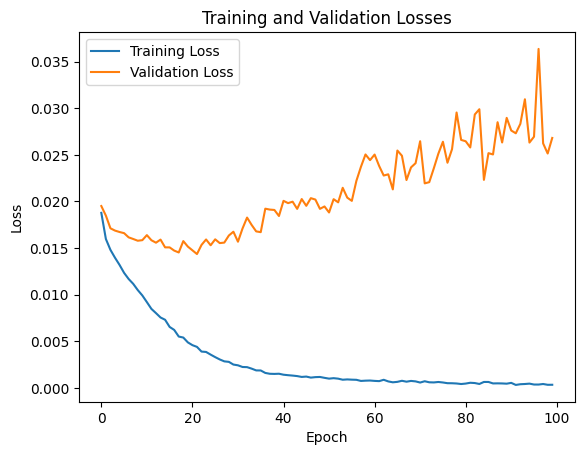

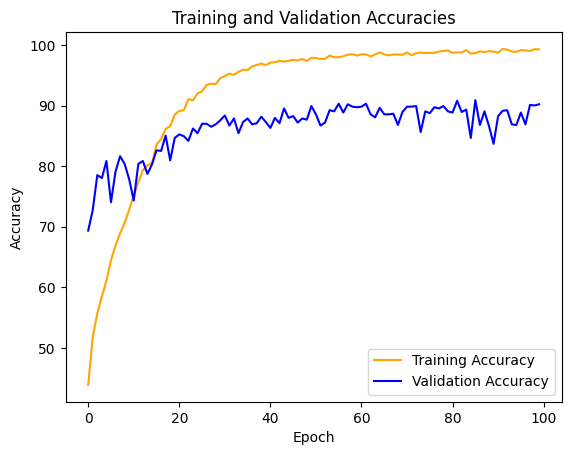

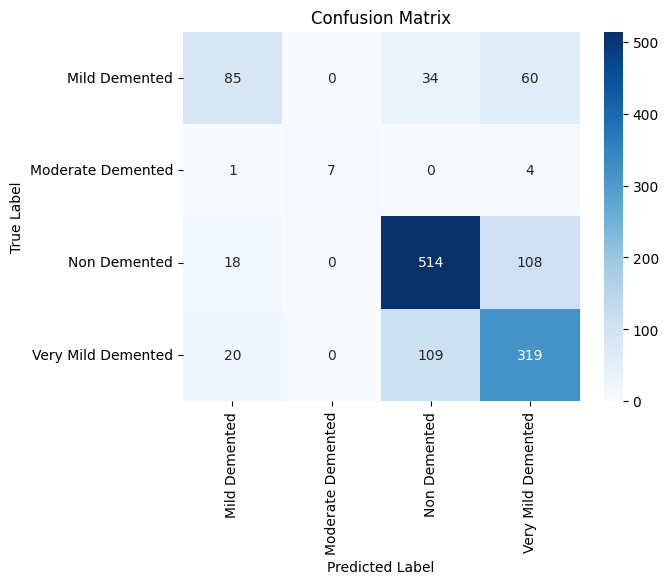


F1 Score:  0.7200359412577138


In [ ]:
# Combine both datasets into one
data_obj = AlzheimerDataset()
combined_dataset = AlzAugmentedDataset(data_obj.train_dataset, augmented_data)

# MAIN PROGRAM
# data_obj = AlzheimerDataset()
model = AlzModel3(num_classes=4).to(device)

#------------------------------------------------------------------------------
#     TRAINING AND VALIDATION
#------------------------------------------------------------------------------
batch_size = 64
num_epochs = 100
total_train = len(combined_dataset)  # Total data points in the training dataset
total_val = len(data_obj.val_dataset)  # Total data points in the validation dataset
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(data_obj.test_dataset, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0005)

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_correct = 0
    train_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predictions = torch.max(outputs.data, 1)
        train_correct += torch.sum(predictions == labels).item()

    train_losses.append(train_loss / total_train)
    train_accuracy = 100.0 * train_correct / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predictions = torch.max(outputs.data, 1)
            val_correct += torch.sum(predictions == labels).item()

    val_losses.append(val_loss / total_val)
    val_accuracy = 100.0 * val_correct / total_val
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch}:, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# PLOT THE LOSSES
plt.plot(list(range(num_epochs)), train_losses, label='Training Loss')
plt.plot(list(range(num_epochs)), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

# PLOT THE ACCURACIES
plt.plot(list(range(num_epochs)), train_accuracies, label='Training Accuracy', color='orange')
plt.plot(list(range(num_epochs)), val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.show()


#------------------------------------------------------------------------------
#     TESTING
#------------------------------------------------------------------------------

model.eval()
test_dataloader = DataLoader(data_obj.test_dataset, batch_size=batch_size)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs.data, 1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
confusion = confusion_matrix(all_labels, all_preds)
# Define class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
# Plot confusion matrix
sns.heatmap(np.array(confusion), annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
print('\nF1 Score: ',f1)

# Results

The best performing model reached an **F1 score of 72%.**

Several models developed on this dataset leveraged pre-trained architectures such as RESNET [1], VGG, and others, achieving remarkable accuracies nearing 94%. Conversely, a different approach employed a more straightforward Convolutional Neural Network model, yielding a validation set accuracy of approximately 80% [2].

This project endeavors to craft a simplified DNN model, boasting fewer parameters than expansive architectures like RESNET, all while upholding high accuracy standards.

Since this project aims to have a ***data-centric approach***, we will keep the model constant, and try to work on improving the data and hyperparameters to acheive better performance.